# METR 3334 - Investigating ENSO and Precipitation with Compositing

In this exercise, we will be be investigating how the El Niño-Southern Oscillation (ENSO) affects global precipitation patterns. We will be doing this investigation by <b>calculating a <u>composite</u></b> of precipitation anomalies during El Niño and La Niña episodes.

First, we will talk a bit about ENSO (see Powerpoint presentation in class). Then, we will talk a bit about <b>composites</b>, which is simply the average of a given field given certain conditions or events. This statistical technique is a powerful one to get an understanding of the <u>average</u> conditions for certain phenomena.

# IMPORT LIBRARIES
<div class="alert alert-block alert-info" style="font-size:16px">Load in the libraries we will need for this exercise.</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dateutil.rrule import rrule, MONTHLY
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

# LOAD IN THE NINO 3.4 INDEX
<div class="alert alert-block alert-info" style="font-size:16px"> First, we need an index to measure the ENSO phenomenon. For this class, we will use the <b>NINO3.4 Index</b>, which measures sea surface temperatures in parts of the east central tropical Pacific. 
    
When this index is positive and relatively large, this denotes an <font color=red><b>El Niño</b></font> episode. When this index is negative and relatively large, this denotes a <font color=blue><b>La Niña</b></font> episode.
    
The index we will load in here is in a text file, so we will use numpy.loadtxt to read in the file.

In [2]:
fileName = 'NINO34.txt'

ENSO = {} # Start a dictionary to store all of the elements for ENSO.
ENSO['index'] = np.loadtxt(fileName,usecols=np.arange(1,13)) # Skip the years column.
ENSO['index'] = ENSO['index'].ravel() # Turn the 2-D matrix into a 1-D vector

# SET UP DATES CORRESPONDING TO EACH INDEX VALUE

<div class="alert alert-block alert-info" style="font-size:16px">This index runs monthly from 1950 to 2021. We will need to set up some date arrays in order to query the index for specific values. Let's use python's datetime module to make the necessary date arrays.</div>

In [3]:
numValues = ENSO['index'].size
start_date = datetime(1979, 1, 1)
ENSO['date'] = np.asarray(list(rrule(freq=MONTHLY, count=numValues, dtstart=start_date))) # Makes an array of monthly dates
ENSO['month'] = np.asarray([d.month for d in ENSO['date']]) # Get the month value for each date.
ENSO['year'] = np.asarray([d.year for d in ENSO['date']]) # Get the year value for each date.


# STANDARDIZE THE INDEX

<div class="alert alert-block alert-info" style="font-size:16px">This index is typically <b><u>standardized</u></b>, which means that it is in units of standard deviations of the sea surface temperature.
    
- A value of +1 means that sea surface temperatures that month are 1 standard deviation <u>above</u> normal.
- A value of -1 means that sea surface temperatures that month are 1 standard deviation <u>below</u> normal.

To standardize an index, we simply subtract the mean of the index from every value and then divide by the standard deviation of the index. You can do this in several ways, but here we will take a "simple" approach.</div>

In [4]:
ENSO['standardized'] = (ENSO['index']-ENSO['index'].mean())/ENSO['index'].std()

# MAKE A SIMPLE PLOT

<div class="alert alert-block alert-info" style="font-size:16px">Let's take a look at what the index looks like over time. We will make a simple line plot (Standardized NINO3.4 Index vs. time).</div>

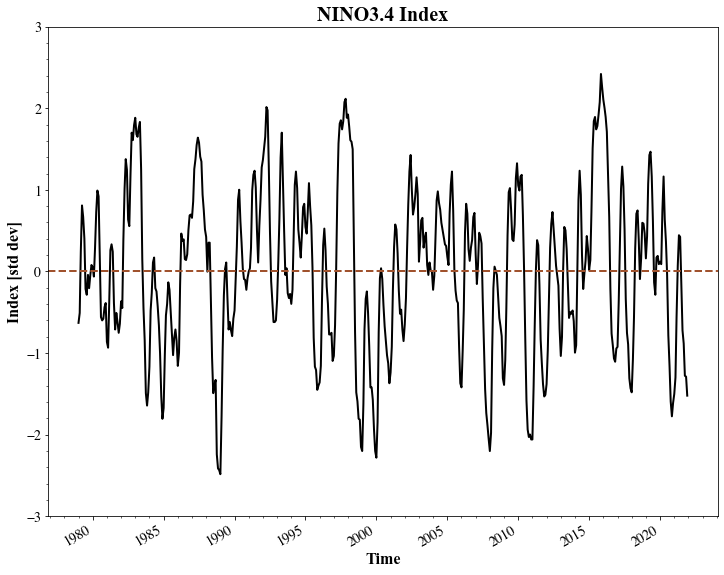

In [5]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.9,0.45])
ax.plot(ENSO['date'],ENSO['standardized'],'k-',lw=2)
ax.axhline(0, color='sienna',linestyle='--',lw=2)
ax.set_title('NINO3.4 Index',name='Times New Roman',size=20,weight='bold')
ax.set_xlabel('Time',name='Times New Roman',size=16,weight='bold')
ax.set_ylabel('Index [std dev]',name='Times New Roman',size=16,weight='bold')

years = YearLocator(5)   # major tick marks every 5 year
months = MonthLocator(1)  # minor tick marks every month
yearsFmt = DateFormatter('%Y')

ax.set(ylim=[-3,3],yticks=np.arange(-3,3.1,1))
for i in (ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels()):
    i.set_family('Times')
    i.set_size(14)
    
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
fig.autofmt_xdate()


# MAKE DEFINITIONS FOR EL NINO AND LA NINA

<div class="alert alert-block alert-info" style="font-size:16px">To get ready for compositing, we need to make definitions of our two (or more) events/categories. In this case, we are working with El Niño (i.e., warmer-than-normal tropical Pacific sea surface temperatures) and La Niña (i.e., colder-than-normal tropical Pacific sea surface temperatures) episodes. So, we need <b><u>two</u></b> categories.

<br>
Let's be clear - <b>YOU CHOOSE THE DEFINITIONS.</b> You should always justify why you chose the categories you did, but the ultimate decision will be yours. <b><u>For this exercise</u></b>, we will define months with <b><font color=red>El Niño</font></b> conditions when the standardized NINO34 index is greater than or equal to 1, and <b><font color=blue>La Niña</font></b> conditions when the standardized NINO34 index is less than or equal to -1.

<br>
To find the months in which this is true, we will use the <b>numpy.where()</b> function.</div>

In [6]:
elNino = np.where(ENSO['standardized']>=1)[0] # Returns the indices where this is true.
laNina = np.where(ENSO['standardized']<=-1)[0] # Returns the indices where this is true.

print('Number of El Niño Months: {}'.format(elNino.size))
print('Number of La Niña Months: {}'.format(laNina.size))

Number of El Niño Months: 86
Number of La Niña Months: 85


# MARK EL NINO AND LA NINA EPISODES ON THE GRAPH.

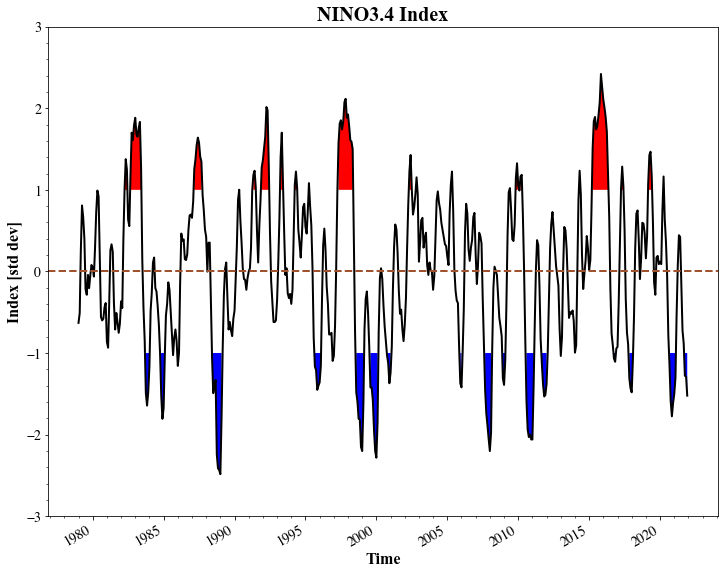

In [7]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.9,0.45])
ax.plot(ENSO['date'],ENSO['standardized'],'k-',lw=2)
ax.axhline(0, color='sienna',linestyle='--',lw=2)
ax.fill_between(ENSO['date'],1,ENSO['standardized'],where=ENSO['standardized']>=1,facecolor='red')
ax.fill_between(ENSO['date'],ENSO['standardized'],-1,where=ENSO['standardized']<=-1,facecolor='blue')
ax.set_title('NINO3.4 Index',name='Times New Roman',size=20,weight='bold')
ax.set_xlabel('Time',name='Times New Roman',size=16,weight='bold')
ax.set_ylabel('Index [std dev]',name='Times New Roman',size=16,weight='bold')

years = YearLocator(5)   # major tick marks every 5 year
months = MonthLocator(1)  # minor tick marks every month
yearsFmt = DateFormatter('%Y')

ax.set(ylim=[-3,3],yticks=np.arange(-3,3.1,1))
for i in (ax.xaxis.get_ticklabels()+ax.yaxis.get_ticklabels()):
    i.set_family('Times')
    i.set_size(14)
    
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
fig.autofmt_xdate()

# LOAD PRECIPITATION DATA

<div class="alert alert-block alert-info" style="font-size:16px">Now that we have the dates for our El Niño and La Niña months, we will next load the atmospheric field we want to composite - <b>monthly-mean precipitation.</b> The precipitation data comes from the <a href="https://psl.noaa.gov/data/gridded/data.gpcp.html">Global Precipitation Climatology Project</a> and spans 1979-present. [Click on the link for information on the dataset, including the grid.] The data are in netCDF format. We will read in the file using the <b>xarray</b> module from Python.

In [8]:
precipFile = 'precip.mon.mean.nc'
ds = xr.open_dataset(precipFile)

#===================================================================
# Print out the content in the file.
#===================================================================
ds

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, time: 518, nv: 2)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2022/01 through latest.

# MAKE PRECIPITATION ANOMALIES

<div class="alert alert-block alert-info" style="font-size:16px">We will now make precipitation anomalies - i.e., departures from the long-term mean. We will do this by month by month (e.g., subtract the January mean precipitation from every individual January value). This is easily done using xarray's built-in functions.</div>

In [9]:
#===================================================================
# Calculate the monthly climatology.
#===================================================================
precipClimo = ds.groupby('time.month').mean()

#===================================================================
# Make the anomalies each month
#===================================================================
precipAnom = ds.groupby('time.month') - precipClimo

#===================================================================
# Look at the anomalies.
#===================================================================
precipAnom

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, time: 518, nv: 2)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-02-01
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1 2
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 -0.02267 -0.03159 ... -0.113 -0.1054

# MAKE THE COMPOSITE MEANS FOR THE PRECIPITATION ANOMALIES
<div class="alert alert-block alert-info" style="font-size:16px">We now have the precipitation anomalies. Using our already determined El Niño and La Niña episodes, we are ready to make our composites. Again, a composite is <b>the average of the variable over all of the events in our category.</b> Using xarray, this is actually very straightforward.</div>


In [10]:
precip_ElNino = precipAnom.sel(time=ENSO['date'][elNino]).mean(dim='time')
precip_LaNina = precipAnom.sel(time=ENSO['date'][laNina]).mean(dim='time')
precip_Difference = precip_ElNino - precip_LaNina

precip_ElNino

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (lat, nv) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lon_bnds  (lon, nv) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precip    (lat, lon) float32 -0.0001304 -0.008977 ... -0.02699 -0.02998

# MAKE PLOTS
<div class="alert alert-block alert-info" style="font-size:16px">We are now ready for make the plots of our results.We will use the python module <b>cartopy</b> for the plots. We are going to make three plots: (a) The El Niño composite precipitation anomalies; (b) The La Niña composite precipitation anomalies; (c) The composite difference ((a) - (b)).</div>

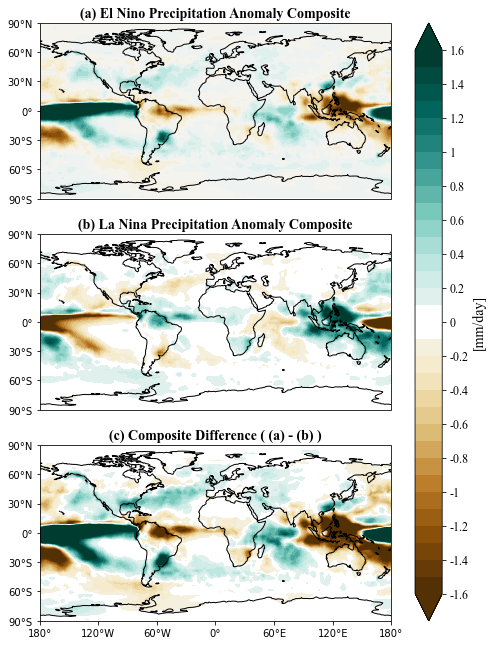

In [11]:
#===================================================================
# Get the levels needed for contouring.
#===================================================================
cmin = -1.6
cmax = 1.7
cint = 0.1
clevs = np.round(np.arange(cmin,cmax,cint),1) 
nlevs = len(clevs) - 1

#===================================================================
# Select a colormap.
#===================================================================
cmap = plt.get_cmap(name='BrBG',lut=nlevs)


#===================================================================
# Define the plot titles.
#===================================================================
plotTitles = ['(a) El Nino Precipitation Anomaly Composite',\
              '(b) La Nina Precipitation Anomaly Composite',\
              '(c) Composite Difference ( (a) - (b) )']


#===================================================================
# Define the figure - 3 subplots all in one column
#===================================================================
fig, ax = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))


#===================================================================
# SUBPLOT 1 - EL NINO COMPOSITE
#===================================================================
plotData = precip_ElNino['precip']
plotData,lons = add_cyclic_point(plotData,coord=precip_ElNino['lon'])
cs = ax[0].contourf(lons,precip_ElNino['lat'],plotData,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap=cmap,extend='both')
cmap._lut[nlevs//2-1:nlevs//2+1] = [1.,1.,1.,1.] # Puts white in the middle for zero


#===================================================================
# SUBPLOT 2 - LA NINA COMPOSITE
#===================================================================
plotData = precip_LaNina['precip']
plotData,lons = add_cyclic_point(plotData,coord=precip_LaNina['lon'])
cs = ax[1].contourf(lons,precip_LaNina['lat'],plotData,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap=cmap,extend='both')
cmap._lut[nlevs//2-1:nlevs//2+1] = [1.,1.,1.,1.] # Puts white in the middle for zero


#===================================================================
# SUBPLOT 3 - COMPOSITE DIFFERENCE
#===================================================================
plotData = precip_Difference['precip']
plotData,lons = add_cyclic_point(plotData,coord=precip_Difference['lon'])
cs = ax[2].contourf(lons,precip_Difference['lat'],plotData,clevs,
                    transform = ccrs.PlateCarree(),
                    cmap=cmap,extend='both')
cmap._lut[nlevs//2-1:nlevs//2+1] = [1.,1.,1.,1.] # Puts white in the middle for zero


#===================================================================
# Format all plots - here we will use a loop.
#===================================================================
for i in range(3):
    
    #===================================================================
    # Latitude labels
    #===================================================================
    ax[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax[i].yaxis.set_major_formatter(lat_formatter)
    
    
    #===================================================================
    # Title
    #===================================================================
    ax[i].set_title(plotTitles[i],name='Times New Roman',weight='bold',size=14)

    
    #===================================================================
    # Draw the coastines for each subplot
    #===================================================================
    ax[i].coastlines()

    
#===================================================================
# Longitude labels - bottom plot only
#===================================================================
ax[2].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax[2].xaxis.set_major_formatter(lon_formatter)


#===================================================================
# Draw the colorbar and add labels.
#===================================================================
cbar = fig.colorbar(cs, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('[{}]'.format(ds.precip.units),name='Times New Roman',size=14)

cticks = []
for i in clevs:
    cticks.append(int(i)) if i.is_integer() else cticks.append(i)

cbar.set_ticks(clevs[::2])
cbar.set_ticklabels(cticks[::2])

for i in cbar.ax.yaxis.get_ticklabels():
    i.set_family('Times New Roman')
    i.set_size(12)
